In [14]:
"""Grover search implemented in QISKit.
This module contains the code necessary to run Grover search on 3
qubits, both with a simulator and with a real quantum computing
device. This code is the companion for the paper
"An introduction to quantum computing, without the physics",
Giacomo Nannicini, https://arxiv.org/abs/1708.03684.
"""

from qiskit import *
from qiskit.tools import visualization

def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.
    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
# -- end function

def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

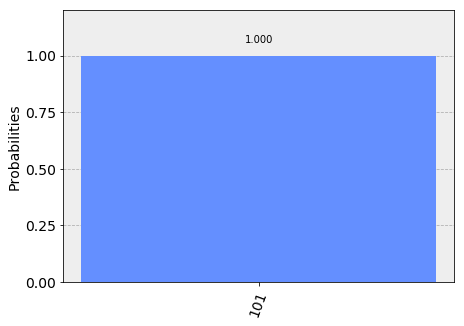

In [24]:
# Make a quantum program for the n-bit Grover search.
n = 3
# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.


f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)
ans = ClassicalRegister(n)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(f_out)
qc.add_register(aux)
qc.add_register(ans)

input_state(qc, f_in, f_out, n)
# Apply two full iterations
black_box_u_f(qc, f_in, f_out, aux, n, exactly_1_3_sat_formula)
inversion_about_average(qc, f_in, n)
black_box_u_f(qc, f_in, f_out, aux, n, exactly_1_3_sat_formula)
inversion_about_average(qc, f_in, n)
# Measure the output register in the computational basis
for j in range(n):
    qc.measure(f_in[j], ans[j])

# Execute circuit
result = execute(qc, Aer.get_backend('qasm_simulator'),
                    coupling_map=None, shots=1024).result()
# Get counts and plot histogram
counts = result.get_counts()
visualization.plot_histogram(counts)

In [25]:
print(result)

Result(backend_name='qasm_simulator', backend_version='0.3.2', date=datetime.datetime(2019, 11, 16, 22, 49, 49, 694227), header=Obj(backend_name='qasm_simulator', backend_version='0.3.2'), job_id='d8fc6768-20c9-4fd5-a451-2d702b5d138d', metadata={'max_memory_mb': 4096, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.000752673}, qobj_id='6d476981-abf9-4577-91ee-d92cc8534957', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x5=1)), header=Obj(clbit_labels=[['c18', 0], ['c18', 1], ['c18', 2]], creg_sizes=[['c18', 3]], memory_slots=3, n_qubits=8, name='circuit33', qreg_sizes=[['q51', 3], ['q52', 1], ['q53', 4]], qubit_labels=[['q51', 0], ['q51', 1], ['q51', 2], ['q52', 0], ['q53', 0], ['q53', 1], ['q53', 2], ['q53', 3]]), meas_level=2, metadata={'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 4}, seed_simulator=1243642389, shots=1, status='DONE', success=True, time_taken=0.000347639)], status='COMPLETED', succe